## 사용 패키지

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.ensemble import RandomForestRegressor

from pycaret.regression import *

## 데이터 로드

In [2]:
train = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/train.csv')
test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')
submission = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/sample_submission.csv')

# temp = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/진주체감온도.csv')
# rain = pd.read_csv(('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/진주강수.csv'))

In [3]:
# temp.columns = ['일자','기온','풍속','체감기온']

In [4]:
# train = pd.merge(train, temp)
# test = pd.merge(test, temp)

In [5]:
# rain.columns = ['일자', '강수량']
# rain.fillna(0, inplace=True)

In [6]:
# train = pd.merge(train,rain)
# test = pd.merge(test, rain)

In [7]:
# plt.figure(figsize=(12,6))
# sns.barplot(train['일'], train['강수량'])

In [8]:
# plt.figure(figsize=(12,6))
# sns.regplot(train2['강수량'] , train2['중식계'])

In [9]:
# expr = train['강수량'] > 80

In [10]:
# train2 = train[expr]

In [11]:
# train2

In [12]:
train.corr()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
본사정원수,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,-0.173852
본사휴가자수,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,-0.316894
본사출장자수,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,0.571168
현본사소속재택근무자수,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057534
중식계,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,0.508287
석식계,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.508287,1.000000


## 데이터

## 요일을 숫자로 매핑

In [13]:
#train['요일'] = train['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})
#test['요일'] = test['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})

## `요일 랭크지정 방식.`
## 석식에만 적용! 석식 수요일이 자기개발의 날 때문에 적어서.

In [14]:
weekdayrankfordinner = {
    '월' : 1,
    '화' : 2,
    '수' : 5,
    '목' : 3,
    '금' : 4
} 

train['요일(석식)'] = train['요일'].map(weekdayrankfordinner)
test['요일(석식)'] = test['요일'].map(weekdayrankfordinner)

## `월, 일을 숫자형으로 변환`

In [15]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

print(train['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.isocalendar().week
train['요일'] = train['일자'].dt.weekday


test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.isocalendar().week
test['요일'] = test['일자'].dt.weekday

train['주'] = train['주'].astype('int') # '주'의 타입이 Uint로 사용이 안되어 int로 변경해줌.
test['주'] = test['주'].astype('int')

0      2016-02-01
1      2016-02-02
2      2016-02-03
3      2016-02-04
4      2016-02-05
          ...    
1200   2021-01-20
1201   2021-01-21
1202   2021-01-22
1203   2021-01-25
1204   2021-01-26
Name: 일자, Length: 1205, dtype: datetime64[ns]


## `0712 비율변수 추가`

In [16]:
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']


test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

<AxesSubplot:xlabel='월', ylabel='중식계'>

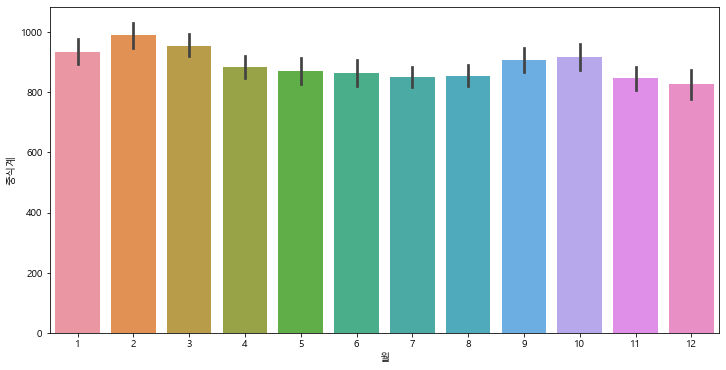

In [17]:
plt.figure(figsize=(12,6))
sns.barplot(train['월'], train['중식계'])

<AxesSubplot:xlabel='월', ylabel='석식계'>

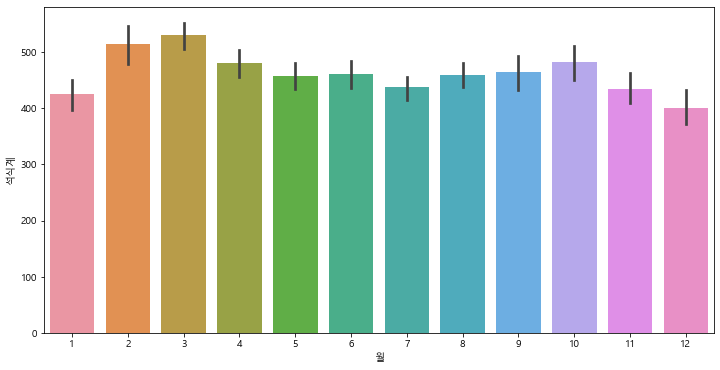

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(train['월'], train['석식계'])

In [19]:
sampletrain = train.loc[:,('주','중식계','석식계')]
sampletrain.groupby(['주']).mean().iloc[:,0].sort_values()

주
52     672.571429
31     761.920000
33     793.000000
30     807.360000
32     822.200000
18     823.500000
46     824.040000
45     826.080000
47     826.120000
21     834.750000
44     847.080000
23     849.476190
51     857.320000
43     859.120000
28     859.600000
29     862.280000
42     863.720000
24     865.458333
17     873.400000
22     879.000000
26     879.700000
25     881.200000
27     881.217391
20     884.440000
15     889.750000
14     892.160000
16     893.375000
50     894.760000
19     897.095238
1      898.727273
3      910.960000
39     911.100000
36     911.520000
48     912.560000
2      913.680000
4      915.250000
37     916.250000
34     918.750000
13     921.400000
49     927.720000
35     933.760000
38     933.760000
12     954.360000
11     955.560000
6      966.157895
5      978.695652
9      983.190476
8      983.200000
10     984.000000
41     999.761905
7     1017.173913
40    1060.125000
Name: 중식계, dtype: float64

In [20]:
sampletrain.groupby(['주']).mean().iloc[:,1].sort_values()

주
52    216.952381
1     392.181818
31    399.000000
4     404.650000
48    404.840000
30    415.160000
26    417.550000
51    419.600000
43    422.800000
44    423.280000
46    426.720000
2     426.880000
17    430.520000
22    433.680000
33    434.285714
39    434.550000
29    434.800000
3     435.200000
32    437.640000
45    440.400000
18    441.937500
5     442.826087
47    443.480000
35    450.200000
23    457.333333
28    457.600000
37    458.850000
21    459.458333
19    464.523810
27    467.086957
24    470.083333
42    476.960000
9     479.428571
20    484.640000
38    484.680000
50    485.720000
25    490.350000
13    492.720000
16    494.666667
49    494.960000
12    505.040000
36    505.400000
15    508.000000
14    511.120000
34    512.958333
6     517.684211
11    539.120000
8     540.520000
7     541.391304
41    558.333333
10    577.240000
40    611.500000
Name: 석식계, dtype: float64

In [21]:
sampletrain = train.loc[:,('월','중식계','석식계')]
sampletrain.groupby(['월']).mean()

,중식계,석식계
월,,
1,934.247525,424.564356
2,989.623656,514.860215
3,953.607477,530.700935
4,883.621359,480.825243
5,869.787879,458.131313
6,863.311111,460.355556
7,848.736364,437.300000
8,854.785047,459.485981
9,907.148936,463.617021


In [22]:
expr = (train['년']>=2020) & (train['월'] >=1) & (train['월']<=4 )

In [23]:
train[expr].mean()

요일                   1.969697
본사정원수             2916.272727
본사휴가자수             141.030303
본사출장자수             194.181818
본사시간외근무명령서승인건수     347.727273
현본사소속재택근무자수        180.494949
중식계                931.979798
석식계                459.676768
요일(석식)               2.959596
년                 2020.171717
월                    2.252525
일                   15.464646
주                    8.373737
휴가비율                 0.048406
출장비율                 0.066741
재택비율                 0.060831
dtype: float64

## `월 랭크지정 방식` 낮은게 12 큰게 1 요일 랭크와 동일

In [24]:
month1 = {
    1:3,
    2:1,
    3:2,
    4:6,
    5:7,
    6:8,
    7:10,
    8:9,
    9:5,
    10:4,
    11:11,
    12:12
}

month2 = {
    1:11,
    2:2,
    3:1,
    4:4,
    5:8,
    6:6,
    7:9,
    8:7,
    9:5,
    10:3,
    11:10,
    12:12
}
train['월(중식)'] = train['월'].map(month1)
test['월(중식)'] = test['월'].map(month1)

train['월(석식)'] = train['월'].map(month2)
test['월(석식)'] = test['월'].map(month2)

train['월(중식)'] = train['월(중식)'].astype('int') # float형이라 int로 변경
test['월(중식)'] = test['월(중식)'].astype('int')
train['월(석식)'] = train['월(석식)'].astype('int')
test['월(석식)'] = test['월(석식)'].astype('int')

## `주 랭크지정 방식`


In [25]:
#중식
week1 = {
    52	:	52	,
    31	:	51	,
    33	:	50	,
    30	:	49	,
    32	:	48	,
    18	:	47	,
    46	:	46	,
    45	:	45	,
    47	:	44	,
    21	:	43	,
    44	:	42	,
    23	:	41	,
    51	:	40	,
    43	:	39	,
    28	:	38	,
    29	:	37	,
    42	:	36	,
    24	:	35	,
    17	:	34	,
    22	:	33	,
    26	:	32	,
    25	:	31	,
    27	:	30	,
    20	:	29	,
    15	:	28	,
    14	:	27	,
    16	:	26	,
    50	:	25	,
    19	:	24	,
    1	:	23	,
    3	:	22	,
    39	:	21	,
    36	:	20	,
    48	:	19	,
    2	:	18	,
    4	:	17	,
    37	:	16	,
    34	:	15	,
    13	:	14	,
    49	:	13	,
    35	:	12	,
    38	:	11	,
    12	:	10	,
    11	:	9	,
    6	:	8	,
    5	:	7	,
    9	:	6	,
    8	:	5	,
    10	:	4	,
    41	:	3	,
    7	:	2	,
    40	:	1	
}

#석식 위부터 작은수임

week2 = {
    52	:	52	,
    1	:	51	,
    31	:	50	,
    4	:	49	,
    48	:	48	,
    30	:	47	,
    26	:	46	,
    51	:	45	,
    43	:	44	,
    44	:	43	,
    46	:	42	,
    2	:	41	,
    17	:	40	,
    22	:	39	,
    33	:	38	,
    39	:	37	,
    29	:	36	,
    3	:	35	,
    32	:	34	,
    45	:	33	,
    18	:	32	,
    5	:	31	,
    47	:	30	,
    35	:	29	,
    23	:	28	,
    28	:	27	,
    37	:	26	,
    21	:	25	,
    19	:	24	,
    27	:	23	,
    24	:	22	,
    42	:	21	,
    9	:	20	,
    20	:	19	,
    38	:	18	,
    50	:	17	,
    25	:	16	,
    13	:	15	,
    16	:	14	,
    49	:	13	,
    12	:	12	,
    36	:	11	,
    15	:	10	,
    14	:	9	,
    34	:	8	,
    6	:	7	,
    11	:	6	,
    8	:	5	,
    7	:	4	,
    41	:	3	,
    10	:	2	,
    40	:	1	
}

train['주(중식)'] = train['주'].map(week1)
test['주(중식)'] = test['주'].map(week1)

train['주(석식)'] = train['주'].map(week2)
test['주(석식)'] = test['주'].map(week2)

train['주(중식)'] = train['주(중식)'].astype('int') # float형이라 int로 변경
test['주(중식)'] = test['주(중식)'].astype('int')
train['주(석식)'] = train['주(석식)'].astype('int')
test['주(석식)'] = test['주(석식)'].astype('int')

## `연도 랭크지정 방식` 효과 X

In [26]:
# year1 = {
#     2021 : 1,
#     2016 : 3,
#     2017 : 2,
#     2018 : 4,
#     2020 : 5,
#     2019 : 6
# }


# year2 = {
#     2016 : 1,
#     2017 : 3,
#     2018 : 2,
#     2019 : 4,
#     2020 : 5,
#     2021 : 6
# }





# train['년(중식)'] = train['년'].map(year1)
# test['년(중식)'] = test['년'].map(year1)

# train['년(석식)'] = train['년'].map(year2)
# test['년(석식)'] = test['년'].map(year2)

# train['년(중식)'] = train['년(중식)'].astype('int') # float형이라 int로 변경
# test['년(중식)'] = test['년(중식)'].astype('int')
# train['년(석식)'] = train['년(석식)'].astype('int')
# test['년(석식)'] = test['년(석식)'].astype('int')

## `일 랭크지정방식 ` 효과 X 사용안함

## `식사가능자수`

In [27]:
train['식사가능자수'] = (train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수'])
test['식사가능자수'] = (test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수'])

In [28]:
#train['중식참여율'] = train['중식계'] / train['식사가능자수']
#train['석식참여율'] = train['석식계'] / train['식사가능자수']

#test['중식참여율'] = test['중식계'] / test['식사가능자수']
#test['석식참여율'] = test['석식계'] / test['식사가능자수']

In [29]:
train['식사가능자수']

0       2551.0
1       2551.0
2       2545.0
3       2497.0
4       2323.0
         ...  
1200    2517.0
1201    2540.0
1202    2425.0
1203    2549.0
1204    2552.0
Name: 식사가능자수, Length: 1205, dtype: float64

# `0708 공휴일 전후 추가 `

## `0713 공휴일 변경`

In [35]:
drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

KeyError: "['조식메뉴' '중식메뉴' '석식메뉴'] not found in axis"

In [ ]:
train['휴일전날'] = 0
test['휴일다음날'] = 0

In [32]:
train.iloc[131,:]

일자                2016-08-12 00:00:00
요일                                  4
본사정원수                            2644
본사휴가자수                            587
본사출장자수                            215
본사시간외근무명령서승인건수                     60
현본사소속재택근무자수                       0.0
중식계                             708.0
석식계                             410.0
요일(석식)                              4
년                                2016
월                                   8
일                                  12
주                                  32
휴가비율                         0.222012
출장비율                         0.081316
재택비율                              0.0
월(중식)                               9
월(석식)                               7
주(중식)                              48
주(석식)                              34
식사가능자수                         2057.0
공휴일전후                               0
Name: 131, dtype: object

In [36]:


# 2016년
train['휴일전날'][18] = 1
train['휴일전날'][48] = 1
train['휴일전날'][63] = 1
train['휴일전날'][18] = 1
train['휴일전날'][153] = 1

test['휴일다음날'][6] = 1
test['휴일다음날'][19] = 1
test['휴일다음날'][49] = 1
test['휴일다음날'][84] = 1
test['휴일다음날'][133] = 1
test['휴일다음날'][164] = 1

#2017년
train['휴일전날'][246] = 1
train['휴일전날'][269] = 1
train['휴일전날'][310] = 1
train['휴일전날'][311] = 1
train['휴일전날'][331] = 1
train['휴일전날'][380] = 1

test['휴일다음날'][228] = 1
test['휴일다음날'][247] = 1
test['휴일다음날'][268] = 1
test['휴일다음날'][310] = 1
test['휴일다음날'][311] = 1
test['휴일다음날'][332] = 1
test['휴일다음날'][381] = 1
test['휴일다음날'][414] = 1
test['휴일다음날'][468] = 1


#2018년
train['휴일전날'][503] = 1
train['휴일전날'][511] = 1
train['휴일전날'][556] = 1
train['휴일전날'][566] = 1
train['휴일전날'][576] = 1
train['휴일전날'][580] = 1
train['휴일전날'][624] = 1
train['휴일전날'][652] = 1
train['휴일전날'][706] = 1
train['휴일전날'][710] = 1

test['휴일다음날'][472] = 1
test['휴일다음날'][512] = 1
test['휴일다음날'][557] = 1
test['휴일다음날'][567] = 1
test['휴일다음날'][577] = 1
test['휴일다음날'][581] = 1
test['휴일다음날'][625] = 1
test['휴일다음날'][653] = 1
test['휴일다음날'][707] = 1


#2019년
train['휴일전날'][729] = 1
train['휴일전날'][815] = 1
train['휴일전날'][864] = 1
train['휴일전날'][883] = 1
train['휴일전날'][895] = 1
train['휴일전날'][898] = 1
train['휴일전날'][952] = 1
train['휴일전날'][894] = 1
train['휴일전날'][956] = 1

test['휴일다음날'][711] = 1
test['휴일다음날'][734] = 1
test['휴일다음날'][794] = 1
test['휴일다음날'][816] = 1
test['휴일다음날'][865] = 1
test['휴일다음날'][895] = 1
test['휴일다음날'][899] = 1
test['휴일다음날'][953] = 1
test['휴일다음날'][896] = 1


#2020년
train['휴일전날'][972] = 1
train['휴일전날'][1028] = 1
train['휴일전날'][1038] = 1
train['휴일전날'][1039] = 1
train['휴일전날'][1134] = 1
train['휴일전날'][1188] = 1

test['휴일다음날'][957] = 1
test['휴일다음날'][973] = 1
test['휴일다음날'][997] = 1
test['휴일다음날'][1029] = 1
test['휴일다음날'][1040] = 1

#2021년
test['휴일전날'][11] = 1
test['휴일다음날'][22] = 1



# # 원핫인코딩
# train = pd.get_dummies(train, columns=['공휴일전후'])
# test = pd.get_dummies(test, columns=['공휴일전후'])

# test['공휴일전후_0'][20] =1
# test['공휴일전후_1'][20] = 0

ValueError: expr must be a string to be evaluated, <class 'bool'> given

In [37]:
train.query('요일' == '월')

ValueError: expr must be a string to be evaluated, <class 'bool'> given

In [34]:
test['공휴일전후_2']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    1
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
Name: 공휴일전후_2, dtype: uint8

## Feature

In [44]:
#x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
#y1_train = train['중식계']
#y2_train = train['석식계']

#x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [99]:
x1_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']] #중식계
x2_train = train[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수','월(석식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']] #석식계

y1_train = train['중식계']
y2_train = train['석식계']

x1_test = test[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']]
x2_test = test[['요일(석식)', '본사시간외근무명령서승인건수', '식사가능자수', '월(석식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수']]

## 점심과 저녁을 식수 인원을 예측할 2개 모델 생성

In [85]:
# model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
# model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

## 학습

In [86]:
# model1.fit(x1_train, y1_train) #중식계
# model2.fit(x2_train, y2_train) #석식계

## 추론

In [87]:
# pred1 = model1.predict(x1_test)
# pred2 = model2.predict(x2_test)

## 결과 제출

In [88]:
# submission['중식계'] = pred1
# submission['석식계'] = pred2

In [89]:
# submission.to_csv('baseline.csv', index=False)

# `Kfold 적용 버전`

In [90]:
# from sklearn.model_selection import KFold
# k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

In [91]:
# model1.fit(x1_train, y1_train) #중식계
# model2.fit(x2_train, y2_train) #석식계

In [92]:
# model1 = cat
# models1 = [] # 교차검증을 위한 바구나 5개

# for train_idx, val_idx in k_fold.split(x1_train):
#     x1_t = x1_train.iloc[train_idx]
#     y1_t = y1_train.iloc[train_idx]
#     x1_val = x1_train.iloc[val_idx]
#     y1_val = y1_train.iloc[val_idx]
    
#      models1.append(model1.fit(x1_t, y1_t))#, eval_set = (x1_val, y1_val), early_stopping_rounds=100, verbose = 100))

# preds1 = []
# for model1 in models1:
#     preds1.append(model1.predict(x1_test))    


# model2 = cat
# models2 = [] # 교차검증을 위한 바구나 5개

# for train_idx, val_idx in k_fold.split(x2_train):
#     x2_t = x2_train.iloc[train_idx]
#     y2_t = y2_train.iloc[train_idx]
#     x2_val = x2_train.iloc[val_idx]
#     y2_val = y2_train.iloc[val_idx]
    
#     models2.append(model2.fit(x2_t, y2_t))#, eval_set = (x2_val, y2_val), early_stopping_rounds=100, verbose = 100))
    

# preds2 = []
# for model2 in models2:
#     preds2.append(model2.predict(x2_test))

In [93]:
# pred1 = np.mean(preds1, axis=0)
# pred2 = np.mean(preds2, axis=0)

In [94]:
# submission['중식계'] = pred1
# submission['석식계'] = pred2

In [95]:
# submission.to_csv('baseline0712.csv', index=False)

## `앙상블 모델 적용 버전`

In [96]:
# 메뉴
train_lunch = pd.concat([x1_train, train['중식계']], axis = 1) # concat cbind 역할
train_dinner = pd.concat([x2_train, train['석식계']], axis = 1)
test_lunch = pd.concat([x1_test], axis = 1)
test_dinner = pd.concat([x2_test], axis = 1)
print('done')

done


### 중식 모델링

In [97]:
reg = setup(data=pd.concat([x1_train,train['중식계']], axis=1), # concat cbind 역할
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)
print('done')

,Description,Value
0,session_id,390
1,Target,중식계
2,Original Data,"(1205, 10)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 13)"


done


In [76]:
best_5_l = compare_models(sort='MAE', n_select=5)
print('done')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,73.3221,10017.6116,99.5353,0.7730,0.1244,0.0902,1.6490
gbr,Gradient Boosting Regressor,73.5520,10174.4173,100.2624,0.7694,0.1239,0.0895,0.0640
rf,Random Forest Regressor,75.1922,11106.5021,104.4236,0.7485,0.1320,0.0935,0.2510
et,Extra Trees Regressor,76.1890,11232.9862,105.2681,0.7455,0.1321,0.0938,0.2370
huber,Huber Regressor,78.7961,11826.4216,108.1660,0.7342,0.1386,0.0979,0.0320
lightgbm,Light Gradient Boosting Machine,80.0010,11373.5139,106.0187,0.7430,0.1324,0.0978,0.0430
lar,Least Angle Regression,80.0760,11547.0123,106.9110,0.7399,0.1443,0.0987,0.0120
lr,Linear Regression,80.0760,11547.0123,106.9110,0.7399,0.1443,0.0987,0.0170
br,Bayesian Ridge,80.2770,11571.4505,107.0674,0.7393,0.1407,0.0990,0.0180
ridge,Ridge Regression,80.3392,11541.1701,106.9474,0.7399,0.1380,0.0991,0.0110


done


In [77]:
blended_l = blend_models(estimator_list= best_5_l, fold=5, optimize='MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)

pred_esb_l = predict_model(final_model_l, test_lunch)

pred_esb_l['Label']

submission_esb = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/sample_submission.csv')
submission_esb['중식계'] = pred_esb_l['Label']

print('done')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,69.5567,8712.2900,93.3396,0.8037,0.1143,0.0847
1,75.7185,10530.7311,102.6194,0.7619,0.1313,0.0933
2,77.2909,10954.7669,104.6650,0.7366,0.1315,0.0963
3,71.9506,11578.5884,107.6038,0.7598,0.1445,0.0944
4,68.7668,8294.2037,91.0725,0.8198,0.1089,0.0815
Mean,72.6567,10014.1160,99.8601,0.7764,0.1261,0.0901
SD,3.3493,1284.6897,6.4870,0.0307,0.0129,0.0058


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,67.3379,7881.7225,88.7791,0.8078,0.1105,0.0825


done


### 석식모델링

In [78]:
reg = setup(data=pd.concat([x2_train,train['석식계']], axis=1), # concat cbind 역할
            target='석식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)
print('done')

,Description,Value
0,session_id,6988
1,Target,석식계
2,Original Data,"(1205, 10)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 13)"


done


In [79]:
best_5_d = compare_models(sort = 'MAE', n_select = 5)
print('done')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,60.9763,8213.4897,89.5913,0.5110,0.8570,0.1288,1.9030
rf,Random Forest Regressor,61.7414,8375.0423,90.5691,0.5052,0.8546,0.1321,0.3110
et,Extra Trees Regressor,61.8092,8159.9201,89.1196,0.5001,0.8295,0.1331,0.2530
gbr,Gradient Boosting Regressor,63.6468,8612.0231,92.1067,0.4938,0.8688,0.1351,0.0860
lightgbm,Light Gradient Boosting Machine,64.1286,8483.9992,91.5069,0.4887,0.8555,0.1370,0.0550
huber,Huber Regressor,67.1160,9962.3589,98.8354,0.4235,0.8941,0.1434,0.0460
ridge,Ridge Regression,69.2694,9649.4815,97.4589,0.4348,0.8814,0.1472,0.0100
lr,Linear Regression,69.3048,9638.0548,97.3982,0.4351,0.8823,0.1482,0.0190
lar,Least Angle Regression,69.3048,9638.0548,97.3982,0.4351,0.8823,0.1482,0.0120
br,Bayesian Ridge,69.4358,9709.1361,97.7626,0.4320,0.8830,0.1476,0.0110


done


In [80]:
blended_d = blend_models(estimator_list = best_5_d, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_dinner)
print('done')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,56.0801,5627.5106,75.0167,0.6000,0.6319,0.1215
1,55.9304,7193.0521,84.8119,0.5909,0.9903,0.1328
2,72.1073,11457.0511,107.0376,0.4977,1.2706,0.1299
3,61.8788,7656.0311,87.4987,0.4184,0.4732,0.1514
4,60.1096,9181.4222,95.8197,0.5294,1.0476,0.1112
Mean,61.2212,8223.0134,90.0369,0.5273,0.8827,0.1293
SD,5.9093,1974.6631,10.7872,0.0664,0.2898,0.0133


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,69.3448,10760.1691,103.7312,0.5369,1.4020,0.1254


done


In [81]:
pred_esb_d = predict_model(final_model_d, test_dinner)

In [82]:
submission_esb['석식계'] = pred_esb_d['Label']
submission_esb

,일자,중식계,석식계
0,2021-01-27,977.296136,279.087353
1,2021-01-28,957.786366,452.745365
2,2021-01-29,627.556535,245.188731
3,2021-02-01,1270.027091,510.441947
4,2021-02-02,1025.935980,540.074768
5,2021-02-03,1067.040990,392.120481
6,2021-02-04,998.194358,543.104402
7,2021-02-05,708.133145,266.045642
8,2021-02-08,1273.149205,684.642970
9,2021-02-09,1056.771865,580.353797


In [216]:
submission_esb.to_csv('ensembleW.csv', index = False)

- 0708 23:11

randomforest default mae로 바꿈(대회 측정방식)->mae:73 mse:66 오히려 mse가 더 좋게나왔음..

- 0709 00:28

출장자수 변수추가했더니 1점 높게나옴. 추가할 것

- 0709 20:35
    
체감온도 추가 효과 오히려 감소

- 0709 21:38

월 매핑 -> 0.5점 상승! 체감온도는 그냥 뺐음..

---
- 0710 01:51

앙상블 모델 적용.
효과는 안좋았음. 테스트용으로만 써보자.


`중식` 중식개선필요.

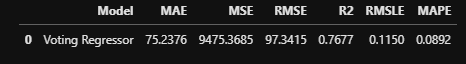

`석식`

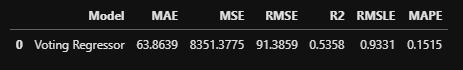

---
- 0711 13:59
    
월 매핑 제대로 안돼있었음.. 수정 후 제출! 63.792 `최고기록`

`중식`

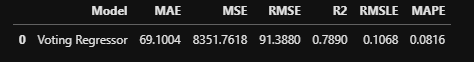

`석식`

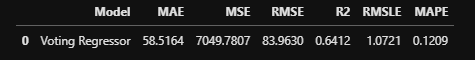


---
- 0711 14:46

연도 매핑 후 연도 추가. 중식은 성능 안좋길래 석식만 넣고 제출 그런데 결과는 68점; 연도 다시 제거!!

`중식`

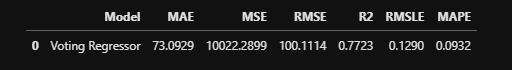

`석식`

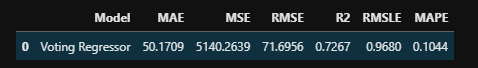

---
- 0711 17:03

일 매핑. 결과 안좋음.. 제거!

---
- 0711 17:26
    
휴가자수 식사가능자수에서 뺐지만 따로 추가해주었음. 파일명 : ensembleVacc.csv

`중식`

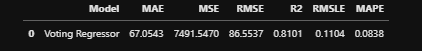

`석식` 

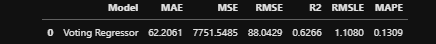

---
- 0711 17:51
    
식사가능자수 <- 식사가능자수/본사정원수로 잠시 변경, 휴가자수도 뺌

`중식`

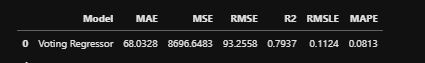

`석식`

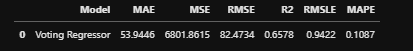

제출결과 안좋음.. 다시 복구

---
- 0712 00:23

휴가자수 임의로 더한걸 뺀다고 생각하고 출장자수를 없앴었음.... 그래서 계속 작게나옴;

이번엔 주, 년을 모두 추가하고 돌려봤다./ 해사꺼 비율시리즈 다 추가했더니 72점나옴.....

`중식`

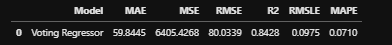

`석식`

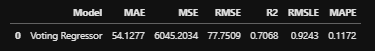

---
- 0712 01:15
    
최고기록에 주 랭크매핑 후 제출. 66.195점.. 낮게나옴



`중식`

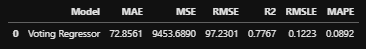

`석식`

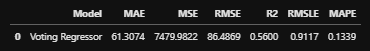

---
- 0714 
일 대신 주를 넣어서 비교.

`일을넣은 앙상블`

중식

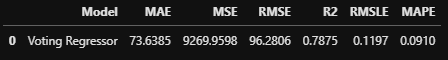

석식

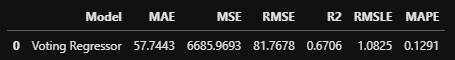

`주를넣은 앙상블`


중식

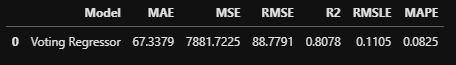

석식

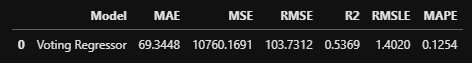

중식은 주를 넣고 석식은 일을 넣어보자 > 3점 더 안좋게나옴.. 그대로 일을 쓰자..

# `Catboost + Kfold`

In [ ]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

model1 = cat
model2 = cat

model1.fit(x1_train, y1_train) #중식계
pred1 = model1.predict(x1_test)

model2.fit(x2_train, y2_train) #석식계
pred2 = model2.predict(x2_test)

from sklearn.model_selection import KFold

k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

model1 = cat
models1 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x1_train):
    x1_t = x1_train.iloc[train_idx]
    y1_t = y1_train.iloc[train_idx]
    x1_val = x1_train.iloc[val_idx]
    y1_val = y1_train.iloc[val_idx]
    
    models1.append(model1.fit(x1_t, y1_t, eval_set = (x1_val, y1_val), early_stopping_rounds=100, verbose = 100))

preds1 = []
for model1 in models1:
    preds1.append(model1.predict(x1_test))    


model2 = cat
models2 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x2_train):
    x2_t = x2_train.iloc[train_idx]
    y2_t = y2_train.iloc[train_idx]
    x2_val = x2_train.iloc[val_idx]
    y2_val = y2_train.iloc[val_idx]
    
    models2.append(model2.fit(x2_t, y2_t, eval_set = (x2_val, y2_val), early_stopping_rounds=100, verbose = 100))
    

preds2 = []
for model2 in models2:
    preds2.append(model2.predict(x2_test))
    
pred1 = np.mean(preds1, axis=0)
pred2 = np.mean(preds2, axis=0)

submission['중식계'] = pred1
submission['석식계'] = pred2

submission.to_csv('catKfold.csv', index=False)

# `Catboost 만 `

In [98]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

model1 = cat
model2 = cat

model1.fit(x1_train, y1_train) #중식계
pred1 = model1.predict(x1_test)

model2.fit(x2_train, y2_train) #석식계
pred2 = model2.predict(x2_test)

submission['중식계'] = pred1
submission['석식계'] = pred2


submission.to_csv('catweek.csv', index=False)

Learning rate set to 0.040347
0:	learn: 203.8435503	total: 2.87ms	remaining: 2.87s
1:	learn: 198.6994585	total: 5.99ms	remaining: 2.99s
2:	learn: 193.5746831	total: 9.46ms	remaining: 3.14s
3:	learn: 188.7899592	total: 12ms	remaining: 2.98s
4:	learn: 184.3252841	total: 13.9ms	remaining: 2.76s
5:	learn: 179.8663227	total: 15.8ms	remaining: 2.62s
6:	learn: 175.6196980	total: 18.1ms	remaining: 2.56s
7:	learn: 171.4992952	total: 20.8ms	remaining: 2.57s
8:	learn: 167.7525035	total: 22.7ms	remaining: 2.5s
9:	learn: 164.0593854	total: 24.6ms	remaining: 2.43s
10:	learn: 160.5199644	total: 26.8ms	remaining: 2.41s
11:	learn: 157.1542124	total: 32.7ms	remaining: 2.69s
12:	learn: 154.1334929	total: 35.8ms	remaining: 2.72s
13:	learn: 151.6650158	total: 40.4ms	remaining: 2.85s
14:	learn: 148.6533540	total: 44.6ms	remaining: 2.93s
15:	learn: 145.9750028	total: 48.1ms	remaining: 2.96s
16:	learn: 143.3362736	total: 51.3ms	remaining: 2.96s
17:	learn: 141.1430956	total: 55.3ms	remaining: 3.02s
18:	learn: 

# `NEW CatBOOST` 석식계로 중식계를 예측

In [ ]:
# # 일단 석식계만 예측

# from catboost import CatBoostRegressor
# cat = CatBoostRegressor()

# model1 = cat
# model2 = cat

# model2.fit(x2_train, y2_train) #석식계
# pred2 = model2.predict(x2_test)

# submission['석식계'] = pred2

In [34]:
# # 예측한 걸 테스트에 변수로 넣음
# test['석식계'] = pred2

In [35]:
# # 예측한 걸 테스트에 변수로 넣음
# x1_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수','석식계']] #중식계

# x1_test = test[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '월(중식)', '일','공휴일전후_0','공휴일전후_1','공휴일전후_2','본사출장자수','석식계']] #중식계

In [69]:
# # 석식계를 이용해서 중식계 예측

# model1.fit(x1_train, y1_train) #중식계
# pred1 = model1.predict(x1_test)

In [38]:
# # 최종결과
# submission['중식계'] = pred1
# submission['석식계'] = pred2
# submission.to_csv('catlun.csv', index=False)